In [185]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [560]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
import scipy.io as sio
import scipy as sp
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from find_grid_cells import load_data
from calculate_2d_tuning_curve import calculate_2d_tuning_curve
from calculate_spatial_periodicity import calculate_spatial_periodicity
from calculate_correlation_matrix import calculate_correlation_matrix
from analyze_periodicity import analyze_periodicity, Partition_Data
from fourier_transform import (fourier_transform, analyze_fourier, analyze_polar_spectrogram, 
    analyze_fourier_rings, fourier_rings_significance)
from shuffle_rate_map import shuffle_rate_map
from plot_data import (plot_canonical_scoring_method, plot_analyze_correlation_periodicity, plot_fourier_scoring,  
    plot_polar_components, plot_rho_mean_power, plot_ring_power, plot_ring_random_distribution, 
    plot_ring_power_distributions, plot_basic_info)

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import timeit

# Reading in data

In [187]:
store = pd.HDFStore('JZ1_mec_openfield.h5', mode='r')

position = store.select('position')

position.head()

time  x_position  y_position  \
animal day epoch timedelta                                                 
JZ1    1   6     02:17:56.199800 02:17:56.199800   23.103026   36.552946   
                 02:17:56.233466 02:17:56.233466   23.184507   36.400532   
                 02:17:56.267066 02:17:56.267066   23.277276   36.258774   
                 02:17:56.300666 02:17:56.300666   23.398752   36.117688   
                 02:17:56.334300 02:17:56.334300   23.502401   35.999961   

                                  head_direction     speed  
animal day epoch timedelta                                  
JZ1    1   6     02:17:56.199800       -2.576741  2.591167  
                 02:17:56.233466       -2.616583  2.581048  
                 02:17:56.267066       -2.643939  2.560883  
                 02:17:56.300666       -2.661241  2.530817  
                 02:17:56.334300       -2.670043  2.491072

In [188]:
df = pd.read_pickle('cleaned_spikes_dataframe.pkl')
df.head()

x_position  y_position  \
animal day epoch ntrode cluster timedelta                                 
JZ1    1   6     2      4       02:17:56.318733   23.502401   35.999961   
                                02:17:57.496366   25.087117   36.781239   
                                02:17:57.951233   24.812331   36.525759   
                                02:17:58.506633   23.943983   34.338590   
                                02:17:58.936233   25.851836   32.132330   

                                                 head_direction     speed  
animal day epoch ntrode cluster timedelta                                  
JZ1    1   6     2      4       02:17:56.318733       -2.670043  2.491072  
                                02:17:57.496366       -2.718391  1.181380  
                                02:17:57.951233       -2.746937  2.231058  
                                02:17:58.506633       -2.273309  3.797272  
                                02:17:58.936233       -1.804186  4.424660

In [189]:
index = []
for animal in df.index.get_level_values('animal').unique():
    for day in df.loc[animal].index.get_level_values('day').unique():
        for epoch in df.loc[animal, day].index.get_level_values('epoch').unique():
            for ntrode in df.loc[animal, day, epoch].index.get_level_values('ntrode').unique():
                for cluster in df.loc[animal, day, epoch, ntrode].index.get_level_values('cluster').unique():
                    index.append([animal, day, epoch, ntrode, cluster])

In [404]:
i = index[1]
animal, day, epoch, ntrode, cluster = i[0], i[1], i[2], i[3], i[4]

filename = animal + '_' + str(day) + '_' + str(epoch) + '_' + str(ntrode) + '_' + str(cluster)
print(filename)

spikes_df = df.loc[animal, day, epoch, ntrode, cluster].reset_index()
print(len(spikes_df))
spikes_df.head()

JZ1_1_6_3_45
1897


,timedelta,x_position,y_position,head_direction,speed
0,02:17:57.904133,24.961327,36.614730,-2.757793,2.114504
1,02:17:58.049366,24.359651,36.155427,-2.694460,2.568392
2,02:18:00.435366,33.642495,30.184228,-0.782387,1.799869
3,02:18:00.883566,32.643448,29.510085,-1.049165,2.046653
4,02:18:04.603600,30.813767,24.055142,-1.195944,2.932148


# Running MEC cell classification code

In [622]:
starttime = timeit.default_timer()

cell_names = []
grid_scores = []
grid_cell = []
max_num_partitions = []
max_fourier_power = []
is_periodic = []
dip_test = []
all_maxima_radii = []
sig_maxima_radii = []

# 18, 58 doesn't work
# got up to 42
for count, i in enumerate(index):
    animal, day, epoch, ntrode, cluster = i[0], i[1], i[2], i[3], i[4]

    filename = animal + '_' + str(day) + '_' + str(epoch) + '_' + str(ntrode) + '_' + str(cluster)
    
    if filename == 'JZ1_4_6_2_53' or filename == 'JZ1_9_6_14_6':
        continue
    
    foldername = 'demetris_images'
    cell_names.append(filename)
    
    elapsedtime = timeit.default_timer() - starttime
    print('Elapsed time: ' + str(elapsedtime))
    print('Running cell ' + str(count + 1) + ' of ' + str(len(index)) + ': ' + str(filename))

    # Select correct spike and position data corresponding to current index value 
    spikes_df = df.loc[animal, day, epoch, ntrode, cluster].reset_index()
    pos_df = position.loc[animal, day, epoch].drop('time', axis=1).reset_index()
    
    # Adjust posx and posy data to be within range 0-100
    posx = pos_df['x_position']
    posy = pos_df['y_position']
    posx = np.interp(posx, (posx.min(), posx.max()), (0, 100))
    posy = np.interp(posy, (posy.min(), posy.max()), (0, 100))
    
    # Change spike and position timestamps to be in terms of seconds after first positional timestamp
    spikes_df['timedelta'] = spikes_df['timedelta'].dt.total_seconds() - pos_df['timedelta'].dt.total_seconds()[0]
    pos_df['timedelta'] = pos_df['timedelta'].dt.total_seconds() - pos_df['timedelta'].dt.total_seconds()[0]
    
    dt = pos_df.diff()['timedelta'].mean()

    # Generate spiketrain from spike and position timestamps 
    pos_ts = np.array(pos_df['timedelta'])
    t = pos_ts
    last_el = pos_ts[-1] + dt
    pos_ts_buckets = np.append(pos_ts, last_el)
    
    spikes_ts = np.array(spikes_df['timedelta'])
    
    spiketrain = np.histogram(spikes_ts, pos_ts_buckets)[0]

    filterArray = np.reshape(signal.gaussian(9, 2), (9, 1))
    filterArray = filterArray / np.sum(filterArray)
    firingRate = spiketrain / dt
    firingRate = np.reshape(firingRate, (firingRate.shape[0], 1))
    smoothFiringRate = signal.convolve(firingRate, filterArray, 'same')
    
    meanFr = np.sum(spiketrain) / t[-1]

    unsmoothRateMap, smoothRateMap = calculate_2d_tuning_curve(posx, posy, smoothFiringRate, 20, 0, 100)
    
    correlationMatrix = calculate_correlation_matrix(smoothRateMap)

    # Canonical grid scoring method
    print('Canonical grid scoring method')
    rotations, correlations, gridScore, circularMatrix, threshold = calculate_spatial_periodicity(correlationMatrix)
    plot_canonical_scoring_method(filename, foldername, unsmoothRateMap, meanFr, correlationMatrix, rotations, correlations, gridScore, circularMatrix, threshold)
    grid_scores.append(gridScore)
    if gridScore > 0:
        grid_cell.append(True)
    else:
        grid_cell.append(False)
    
    # Correlation partitioning method
    print('Correlation partitioning method')
    collapsePartitionData, maxCollapseValues = analyze_periodicity(rotations, correlations)
    plot_analyze_correlation_periodicity(filename, foldername, collapsePartitionData, maxCollapseValues)
    maxPartitions = np.argmax(maxCollapseValues) + 3
    max_num_partitions.append(maxPartitions)
    
    # Fourier and polar spectrogram method
    print('Fourier and polar spectrogram method')
    fourierSpectrogram, polarSpectrogram, maxPower, isPeriodic = fourier_transform(unsmoothRateMap, meanFr, spiketrain, dt, posx, posy)
    plot_fourier_scoring(filename, foldername, fourierSpectrogram, polarSpectrogram, maxPower, isPeriodic)
    max_fourier_power.append(maxPower)
    is_periodic.append(isPeriodic)
    
    # Polar spectrogram power annulus method
    print('Polar spectrogram power annulus method')
    area = 1000
    maxRadius = math.ceil((area / (4 * math.pi)) - 1)

    averageRingPower, radii = analyze_fourier_rings(polarSpectrogram, area)
    
    randomDistributions = []
    chunkSizes = [1, 2, 4, 5, 10]
    for size in chunkSizes:
        shuffleAverageRingPower = fourier_rings_significance(unsmoothRateMap, spiketrain, meanFr, dt, posx, posy, area, chunkSize=size)
        randomDistributions.append([size, shuffleAverageRingPower])
    difference = plot_ring_power_distributions(filename, foldername, averageRingPower, radii, area, maxRadius, randomDistributions)
    
    smoothDifference = signal.convolve(difference, filterArray, 'same')
    local_maxima = np.intersect1d(np.where(smoothDifference > 0), signal.argrelmax(smoothDifference))
    all_maxima_radii.append(local_maxima)
    
    less_than_zeros = np.where(smoothDifference <= 0)[0]
    modality = False
    sig_max = []
    for local_max in local_maxima:
        for i in range(len(less_than_zeros)-1):
            if less_than_zeros[i] < local_max and less_than_zeros[i+1] > local_max:
                modality = True
                sig_max.append(local_max)
    dip_test.append(modality)
    sig_maxima_radii.append(sig_max)
    
    # Plot basic information
    plot_basic_info(filename, foldername, unsmoothRateMap, gridScore, meanFr, radii, smoothDifference, maxRadius)
    
    clear_output()

elapsedtime = timeit.default_timer() - starttime
print('Done!')
print('Code took ' + str(elapsedtime) + ' seconds to run')

Done!
Code took 11028.689664331032 seconds to run


In [638]:
classification_data = {'Cell Name': cell_names,
                       'Grid Score': grid_scores,
                       'Grid Cell?': grid_cell,
                       'Max Num Partitions': max_num_partitions,
                       'Max Fourier Power': max_fourier_power,
                       'Sig Max Fourier Power?': is_periodic,
                       'Dip Test?': dip_test, 
                       'All Local Maxima Radii': all_maxima_radii,
                       'Significant Radii': sig_maxima_radii}
classification_data_df = pd.DataFrame(data=classification_data)
classification_data_df.head(10)

,All Local Maxima Radii,Cell Name,Dip Test?,Grid Cell?,Grid Score,Max Fourier Power,Max Num Partitions,Sig Max Fourier Power?,Significant Radii
0,"[0, 14, 32, 48]",JZ1_1_6_2_4,True,True,0.150712,7.555270,6,True,[48]
1,"[0, 3, 27, 45]",JZ1_1_6_3_45,True,False,-0.107597,14.403505,6,True,"[27, 45]"
2,"[0, 4, 32, 66]",JZ1_1_6_10_9,True,True,0.104381,2.852539,6,True,"[32, 66]"
3,"[0, 4, 70]",JZ1_1_6_14_11,True,False,-0.529249,10.215705,4,True,[70]
4,"[0, 4, 28, 50]",JZ1_1_8_2_4,True,False,-0.065837,5.161211,6,True,"[28, 50]"
5,"[0, 6, 33, 62]",JZ1_1_8_10_9,True,False,-0.095293,1.283708,4,True,"[33, 62]"
6,"[0, 11, 27, 41, 56, 71]",JZ1_1_8_14_11,True,False,-0.030234,4.986051,4,True,[56]
7,"[0, 5, 52, 66]",JZ1_2_6_14_3,False,False,-0.201035,8.025525,10,True,[]
8,"[0, 22, 44, 57, 74]",JZ1_2_8_14_3,True,True,0.659713,12.261000,6,True,"[22, 44, 57]"
9,"[0, 3, 22, 35]",JZ1_3_6_2_4,False,False,-0.197092,10.634217,10,True,[]


In [640]:
classification_data_df.to_csv('classification_data.csv')

# Code breakdown/tests

In [598]:
index = []
for animal in df.index.get_level_values('animal').unique():
    for day in df.loc[animal].index.get_level_values('day').unique():
        for epoch in df.loc[animal, day].index.get_level_values('epoch').unique():
            for ntrode in df.loc[animal, day, epoch].index.get_level_values('ntrode').unique():
                for cluster in df.loc[animal, day, epoch, ntrode].index.get_level_values('cluster').unique():
                    index.append([animal, day, epoch, ntrode, cluster])
                    
i = index[1]
animal, day, epoch, ntrode, cluster = i[0], i[1], i[2], i[3], i[4]

filename = animal + '_' + str(day) + '_' + str(epoch) + '_' + str(ntrode) + '_' + str(cluster)
print(filename)

spikes_df = df.loc[animal, day, epoch, ntrode, cluster].reset_index()
print(len(spikes_df))
spikes_df.head()

JZ1_1_6_3_45
1897


,timedelta,x_position,y_position,head_direction,speed
0,02:17:57.904133,24.961327,36.614730,-2.757793,2.114504
1,02:17:58.049366,24.359651,36.155427,-2.694460,2.568392
2,02:18:00.435366,33.642495,30.184228,-0.782387,1.799869
3,02:18:00.883566,32.643448,29.510085,-1.049165,2.046653
4,02:18:04.603600,30.813767,24.055142,-1.195944,2.932148


In [599]:
pos_df = position.loc[animal, day, epoch].drop('time', axis=1).reset_index()
pos_df.head()

,timedelta,x_position,y_position,head_direction,speed
0,02:17:56.199800,23.103026,36.552946,-2.576741,2.591167
1,02:17:56.233466,23.184507,36.400532,-2.616583,2.581048
2,02:17:56.267066,23.277276,36.258774,-2.643939,2.560883
3,02:17:56.300666,23.398752,36.117688,-2.661241,2.530817
4,02:17:56.334300,23.502401,35.999961,-2.670043,2.491072


In [600]:
spikes_df['timedelta'] = spikes_df['timedelta'].dt.total_seconds() - pos_df['timedelta'].dt.total_seconds()[0]
spikes_df.head()

,timedelta,x_position,y_position,head_direction,speed
0,1.704333,24.961327,36.614730,-2.757793,2.114504
1,1.849567,24.359651,36.155427,-2.694460,2.568392
2,4.235567,33.642495,30.184228,-0.782387,1.799869
3,4.683767,32.643448,29.510085,-1.049165,2.046653
4,8.403800,30.813767,24.055142,-1.195944,2.932148


In [601]:
pos_df['timedelta'] = pos_df['timedelta'].dt.total_seconds() - pos_df['timedelta'].dt.total_seconds()[0]
pos_df.head()

,timedelta,x_position,y_position,head_direction,speed
0,0.000000,23.103026,36.552946,-2.576741,2.591167
1,0.033667,23.184507,36.400532,-2.616583,2.581048
2,0.067267,23.277276,36.258774,-2.643939,2.560883
3,0.100867,23.398752,36.117688,-2.661241,2.530817
4,0.134500,23.502401,35.999961,-2.670043,2.491072


In [602]:
posx = pos_df['x_position']
posy = pos_df['y_position']
dt = pos_df.diff()['timedelta'].mean()

In [603]:
pos_ts = np.array(pos_df['timedelta'])
t = pos_ts
last_el = pos_ts[-1] + dt
pos_ts_buckets = np.append(pos_ts, last_el)
pos_ts_buckets[-1] == last_el

True

In [604]:
spikes_ts = np.array(spikes_df['timedelta'])

In [605]:
spiketrain = np.histogram(spikes_ts, pos_ts_buckets)[0]
spiketrain

array([0, 0, 0, ..., 0, 0, 0])

In [606]:
filterArray = np.reshape(signal.gaussian(9, 2), (9, 1))
filterArray = filterArray / np.sum(filterArray)
firingRate = spiketrain / dt
firingRate = np.reshape(firingRate, (firingRate.shape[0], 1))
smoothFiringRate = signal.convolve(firingRate, filterArray, 'same')
smoothFiringRate

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [607]:
posx = np.interp(posx, (posx.min(), posx.max()), (0, 100))
posy = np.interp(posy, (posy.min(), posy.max()), (0, 100))

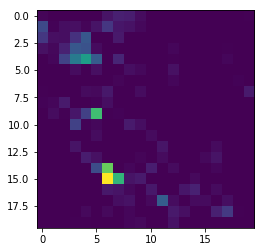

In [608]:
unsmoothRateMap, smoothRateMap = calculate_2d_tuning_curve(posx, posy, smoothFiringRate, 20, 0, 100)

plt.imshow(unsmoothRateMap, interpolation='nearest')
plt.show()

In [609]:
np.nanmean(unsmoothRateMap), np.sum(spiketrain) / t[-1], np.nanmean(smoothRateMap)

(0.43349824129063863, 1.5491776101773838, 0.429612218433962)

In [610]:
rotations, correlations, gridScore, circularMatrix, threshold = calculate_spatial_periodicity(correlationMatrix)

In [611]:
correlationMatrix = calculate_correlation_matrix(smoothRateMap)

rotations, correlations, gridScore, circularMatrix, threshold = calculate_spatial_periodicity(correlationMatrix)

plot_canonical_scoring_method(filename, foldername, unsmoothRateMap, meanFr, correlationMatrix, rotations, correlations, gridScore, circularMatrix, threshold)


In [612]:
collapsePartitionData, maxCollapseValues = analyze_periodicity(rotations, correlations)

plot_analyze_correlation_periodicity(filename, foldername, collapsePartitionData, maxCollapseValues)

In [613]:
meanFr = np.sum(spiketrain) / t[-1]
meanFr

1.5491776101773838

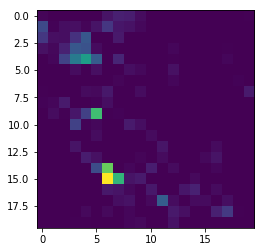

In [614]:
adjustedRateMap = unsmoothRateMap - meanFr
adjustedRateMap[np.where(np.isnan(adjustedRateMap))] = 0
plt.imshow(adjustedRateMap);

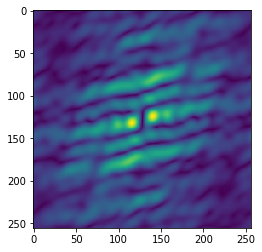

In [619]:
fourierSpectrogram = np.fft.fft2(unsmoothRateMap - np.nanmean(unsmoothRateMap), s=[256, 256])
fourierSpectrogram = fourierSpectrogram / (meanFr * math.sqrt(adjustedRateMap.shape[0] * adjustedRateMap.shape[1]))
fourierSpectrogram = np.fft.fftshift(fourierSpectrogram)
fourierSpectrogram = np.absolute(fourierSpectrogram)
plt.imshow(fourierSpectrogram);

In [620]:
import random 

fourierSpectrogram = np.fft.fft2(unsmoothRateMap - meanFr, s=[256, 256])
fourierSpectrogram = fourierSpectrogram / (meanFr * math.sqrt(adjustedRateMap.shape[0] * adjustedRateMap.shape[1]))
fourierSpectrogram = np.fft.fftshift(fourierSpectrogram)
fourierSpectrogram = np.absolute(fourierSpectrogram)
    
maxPower = np.max(fourierSpectrogram)
    
shiftedPowers = np.empty([150, 65536])
for i in range(150):
    minShift = math.ceil(20 / dt)
    maxShift = len(spiketrain) - (20 / dt)
    randShift = int(round(minShift + random.uniform(0, 1) * (maxShift - minShift)))
        
    shiftedSpiketrain = np.roll(spiketrain, randShift)
    shiftedFiringRate = np.reshape(shiftedSpiketrain / dt, (len(shiftedSpiketrain), 1))
        
    unsmoothShiftedRateMap, smoothShiftedRateMap = calculate_2d_tuning_curve(posx, posy, shiftedFiringRate, 20, 0, 100)
    unsmoothShiftedRateMap = unsmoothShiftedRateMap - meanFr    
    unsmoothShiftedRateMap[np.where(np.isnan(unsmoothShiftedRateMap))] = 0
        
    shiftedFourier = np.fft.fft2(unsmoothShiftedRateMap, s=[256, 256])
    shiftedFourier = shiftedFourier / (meanFr * math.sqrt(unsmoothShiftedRateMap.shape[0] * unsmoothShiftedRateMap.shape[1]))
    shiftedFourier = np.absolute(np.fft.fftshift(shiftedFourier))
    shiftedFourier = shiftedFourier.reshape(-1)
    shiftedPowers[i] = shiftedFourier

# Should 95th percentile be from max power or all the powers of each random fourier spectrogram
# shiftedMaxPowers = np.max(shiftedPowers, axis=1)
sigPercentile = np.percentile(shiftedPowers, 95)
if maxPower > sigPercentile:
    isPeriodic = True
else:
    isPeriodic = False
    
threshold1 = np.percentile(shiftedPowers, 50)
polarSpectrogram = fourierSpectrogram - threshold1
polarSpectrogram[np.where(polarSpectrogram < 0)] = 0

# main components is used to generate the polar graph of the average power along each radial angle 
# aka the flower looking graph
threshold2 = np.max(polarSpectrogram) * 0.1
mainComponents = np.copy(polarSpectrogram)
mainComponents[np.where(polarSpectrogram < threshold2)] = 0


In [621]:
plot_fourier_scoring(filename, foldername, fourierSpectrogram, polarSpectrogram, maxPower, isPeriodic)

In [523]:
area = 1000
maxRadius = math.ceil((area / (4 * math.pi)) - 1)

averageRingPower, radii = analyze_fourier_rings(polarSpectrogram, area)

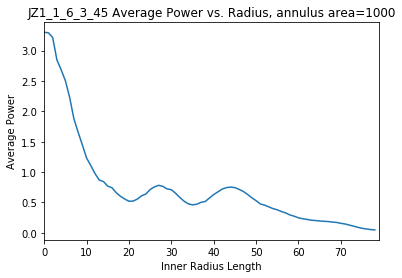

In [524]:
plot_ring_power(filename, averageRingPower, radii, area, maxRadius)

In [527]:
shuffleAverageRingPower = fourier_rings_significance(unsmoothRateMap, spiketrain, t, dt, posx, posy, area, shuffleType='spiketrain')


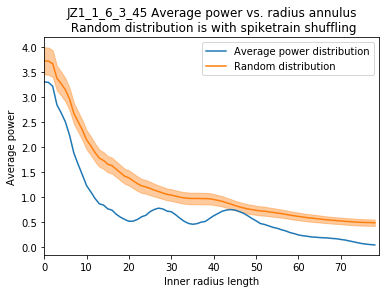

In [541]:
spiketrainRandomDistribution = np.mean(shuffleAverageRingPower, axis=0)
standardDeviation = np.std(shuffleAverageRingPower, axis=0)
marginError = 1.96 * (standardDeviation / math.sqrt(150))
confidenceInterval = np.empty((2, maxRadius))
confidenceInterval[0, :] = spiketrainRandomDistribution - marginError
confidenceInterval[1, :] = spiketrainRandomDistribution + marginError

ax = plt.subplot()
plt.plot(radii, averageRingPower, label='Average power distribution', color='C0')
plt.plot(radii, spiketrainRandomDistribution, label='Random distribution', color='C1')
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], color='C1', alpha=0.4)

plt.title(filename + ' Average power vs. radius annulus\n Random distribution is with spiketrain shuffling')
plt.xlabel('Inner radius length')
plt.ylabel('Average power')
plt.xlim(0, maxRadius)
plt.legend();


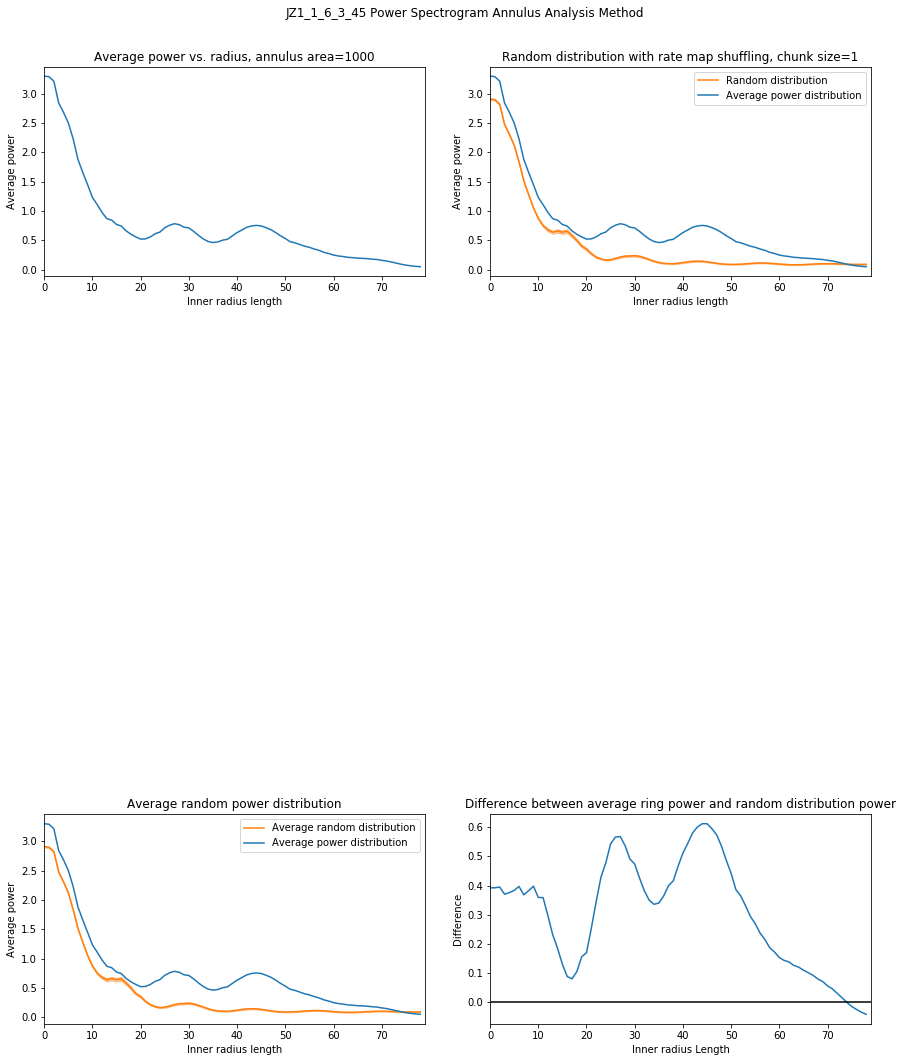

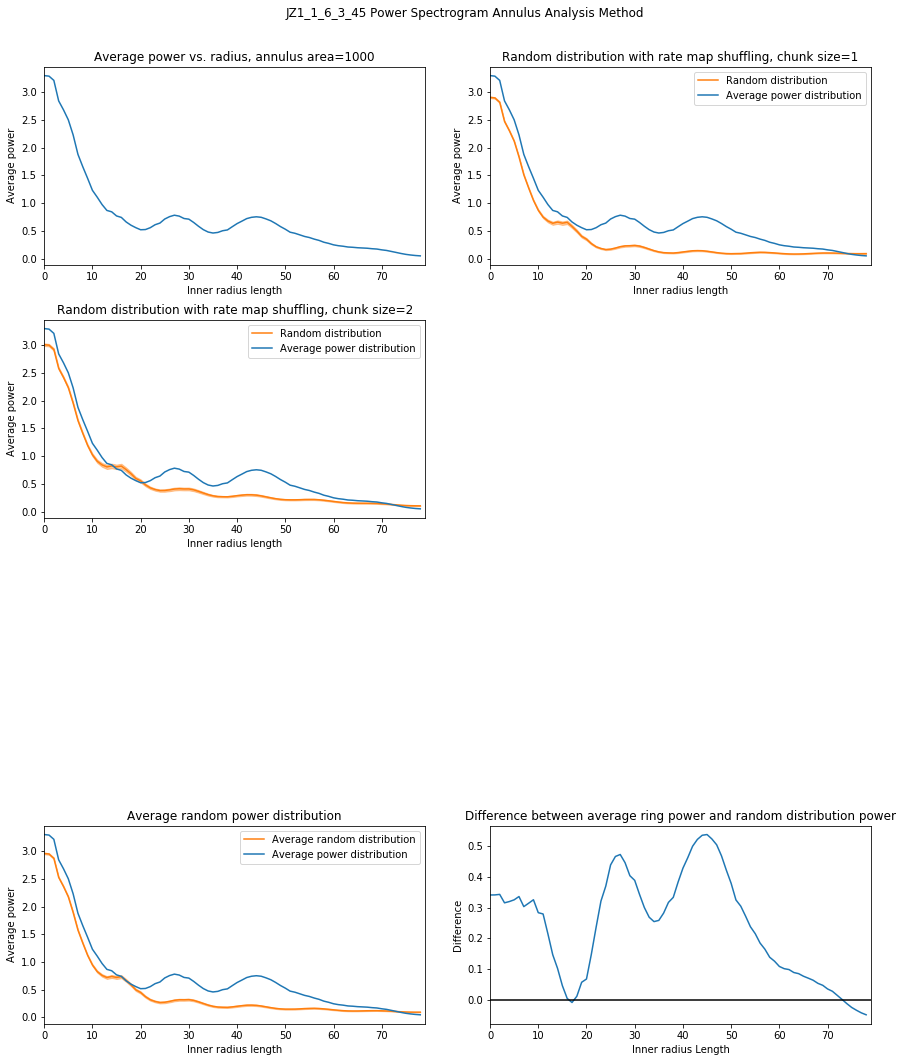

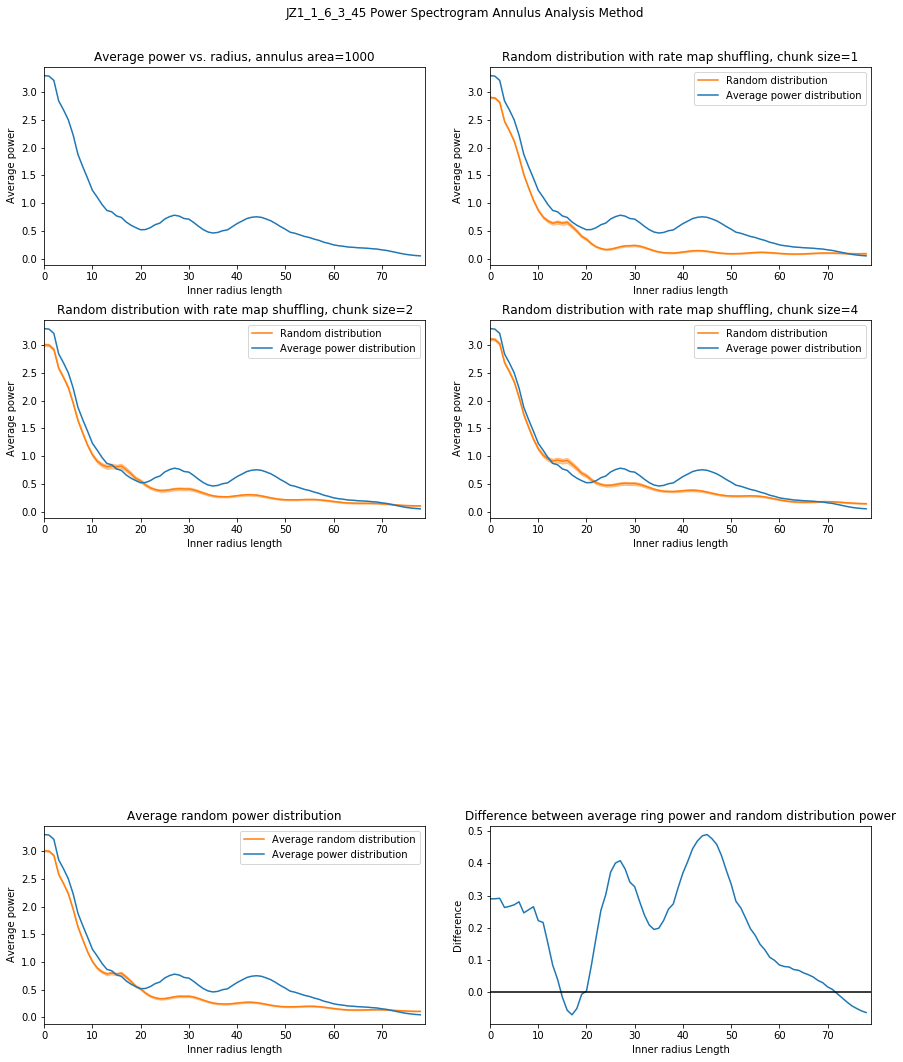

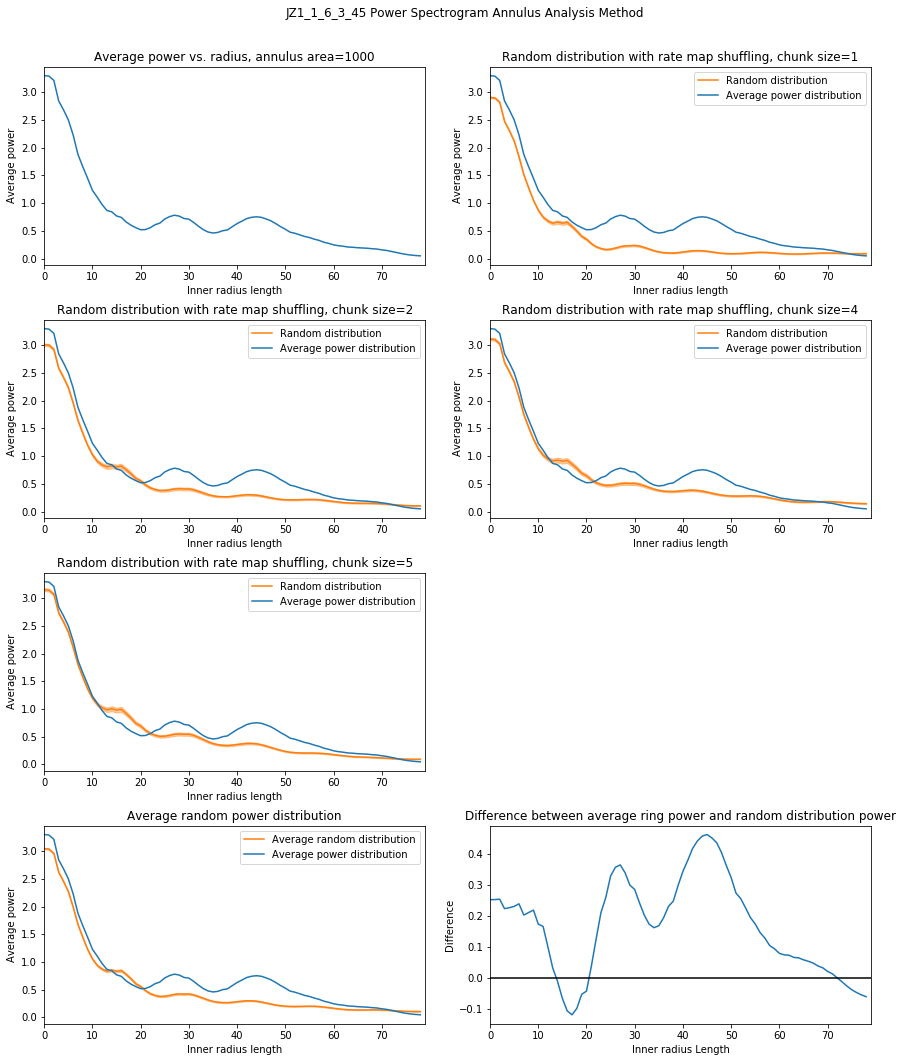

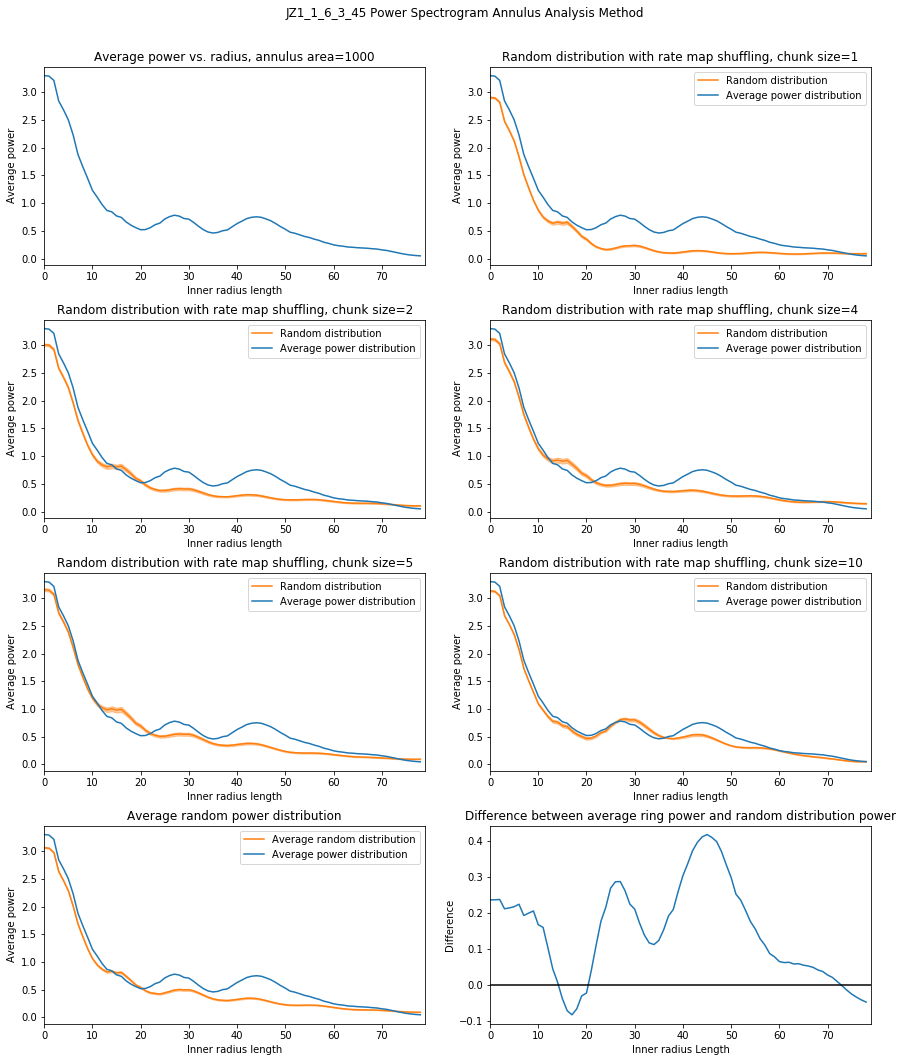

In [545]:
randomDistributions = []
chunkSizes = [1, 2, 4, 5, 10]
for size in chunkSizes:
    shuffleAverageRingPower = fourier_rings_significance(unsmoothRateMap, spiketrain, t, dt, posx, posy, area, shuffleType='rate map', chunkSize=size)
    randomDistributions.append([size, shuffleAverageRingPower])
    difference = plot_ring_power_distributions(filename, foldername, averageRingPower, radii, area, maxRadius, randomDistributions)
